# Sensor Modeling

# This tutorial demonstrates how to model sensor geometries.

## Setup

In [ ]:
import sys

! {sys.executable} -m pip install --quiet numpy --upgrade
! {sys.executable} -m pip install --quiet plotly

# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryCorePy==0.1.9
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryMathematicsPy==0.1.5
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryPhysicsPy==0.1.3

In [1]:
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [2]:
import Library.Core as Core
import Library.Mathematics as Mathematics
import Library.Physics as Physics
import Library.Astrodynamics as Astrodynamics

In [57]:
Object2 = Mathematics.Geometry.D2.Object
Point2 = Mathematics.Geometry.D2.Objects.Point
LineString2 = Mathematics.Geometry.D2.Objects.LineString
Polygon2 = Mathematics.Geometry.D2.Objects.Polygon
Point3 = Mathematics.Geometry.D3.Objects.Point
Polygon3 = Mathematics.Geometry.D3.Objects.Polygon
Ellipsoid = Mathematics.Geometry.D3.Objects.Ellipsoid
Pyramid = Mathematics.Geometry.D3.Objects.Pyramid

Length = Physics.Units.Length
Angle = Physics.Units.Angle
Scale = Physics.Time.Scale
Instant = Physics.Time.Instant
Duration = Physics.Time.Duration
Interval = Physics.Time.Interval
DateTime = Physics.Time.DateTime
LLA = Physics.Coordinate.Spherical.LLA
Position = Physics.Coordinate.Position
Velocity = Physics.Coordinate.Velocity
Frame = Physics.Coordinate.Frame
Environment = Physics.Environment
Geometry = Physics.Environment.Object.Geometry
Earth = Physics.Environment.Objects.CelestialBodies.Earth

Trajectory = Astrodynamics.Trajectory
Orbit = Astrodynamics.Trajectory.Orbit
State = Astrodynamics.Trajectory.State
Access = Astrodynamics.Access

---

## Computation

### Environment

In [58]:
environment = Environment.Default() ;

In [59]:
earth = environment.accessCelestialObjectWithName("Earth")

In [60]:
earth_geometry = earth.getGeometryIn(Frame.ITRF())

### Satellite

Let's define the orbit of a satellite in LEO. In this example, we're modeling the orbit using SGP4.

In [61]:
a = Length.Kilometers(7000.0)
e = 0.0
i = Angle.Degrees(97.0)
raan = Angle.Degrees(0.0)
aop = Angle.Degrees(0.0)
nu = Angle.Degrees(0.0)

coe = Orbit.Models.Kepler.COE(a, e, i, raan, aop, nu)

In [62]:
epoch = Instant.DateTime(DateTime(2018, 1, 1, 0, 0, 0), Scale.UTC)
earth = Environment.Objects.CelestialBodies.Earth.Analytical(epoch)

keplerian_model = Orbit.Models.Kepler(coe, epoch, earth, Orbit.Models.Kepler.PerturbationType.No, True) # True = COE expressed in ITRF frame

In [63]:
keplerian_model.getClassicalOrbitalElements()

-- Classical Orbital Elements ----------------------------------------------------------------------
    Semi-major axis:                         7000000.0000000009 [m]                   
    Eccentricity:                            1.3084570333002971e-16                   
    Inclination:                             97.096826377335631 [deg]                 
    Right ascension of the ascending node:   100.37198541811405 [deg]                 
    Argument of periapsis:                   0.0 [deg]                                
    True anomaly:                            0.020183389751350887 [deg]               
----------------------------------------------------------------------------------------------------

First, we need a **Two-Line Element** (TLE) set:

In [64]:
tle = Orbit.Models.SGP4.TLE("1 25544U 98067A   18231.17878740  .00000187  00000-0  10196-4 0  9994",
                            "2 25544  51.6447  64.7824 0005971  73.1467  36.4366 15.53848234128316")

To setup a **SGP4** orbital model:

In [65]:
sgp4_model = Orbit.Models.SGP4(tle)

We then obtain the satellite orbit (which is a trajectory):

In [89]:
# satellite_orbit = Orbit(keplerian_model, earth)
satellite_orbit = Orbit(sgp4_model, earth)

In [90]:
start_instant = Instant.DateTime(DateTime(2018, 1, 1, 0, 0, 0), Scale.UTC) ;
end_instant = Instant.DateTime(DateTime(2018, 1, 1, 1, 0, 0), Scale.UTC) ;

interval = Interval.Closed(start_instant, end_instant) ;

In [91]:
step = Duration.Minutes(1.0)

In [92]:
instants = interval.generateGrid(step)

In [93]:
states = [satellite_orbit.getStateAt(instant) for instant in instants]

In [94]:
states_lla = [LLA.Cartesian(state.inFrame(Frame.ITRF()).getPosition().getCoordinates(), Earth.EquatorialRadius, Earth.Flattening) for state in states]

In [95]:
states_line_string = LineString2([Point2(state_lla.getLongitude().inDegrees(), state_lla.getLatitude().inDegrees()) for state_lla in states_lla])

In [96]:
ground_track_df = pd.DataFrame([[float(state_lla.getLongitude().inDegrees()), float(state_lla.getLatitude().inDegrees())] for state_lla in states_lla], columns=['Longitude', 'Latitude']) ;

In [97]:
ground_track_df.head()

,Longitude,Latitude
0,-105.144169,-41.239157
1,-101.013630,-43.362869
2,-96.581249,-45.306464
3,-91.836558,-47.044642
4,-86.780520,-48.550854


### Sensor

In [98]:
orbital_frame = None

# orbital_frame = satellite_orbit.getOrbitalFrame(Orbit.FrameType.NED)
orbital_frame = satellite_orbit.getOrbitalFrame(Orbit.FrameType.LVLH)

In [99]:
def calculate_intersection (state, frame, sensor):
    
#     print(state)
#     print(state.inFrame(Frame.ITRF()))
    
    observer_geometry_ORB = Geometry(sensor, frame)
    
#     print(observer_geometry_ORB)
    
    observer_geometry_ITRF = observer_geometry_ORB.inFrame(Frame.ITRF(), state.getInstant())
    
#     print(observer_geometry_ITRF)
    
    observer_geometry_GCRF = observer_geometry_ORB.inFrame(Frame.GCRF(), state.getInstant())
    
#     print(observer_geometry_GCRF)
    
    intersection_ITRF = observer_geometry_ITRF.intersectionWith(earth_geometry)
    
    return intersection_ITRF

In [100]:
apex_NED = Point3(0.0, 0.0, 0.0)
base_NED = Polygon3(Polygon2([Point2(-1.0, -1.0), Point2(+1.0, -1.0), Point2(+1.0, +1.0), Point2(-1.0, +1.0)]), apex_NED + np.array((0.0, 0.0, 1.0)), np.array((1.0, 0.0, 0.0)), np.array((0.0, 1.0, 0.0)))

pyramid_NED = Pyramid(base_NED, apex_NED)

In [101]:
apex_LVLH = Point3(0.0, 0.0, 0.0)
base_LVLH = Polygon3(Polygon2([Point2(-1.0, -1.0), Point2(+1.0, -1.0), Point2(+1.0, +1.0), Point2(-1.0, +1.0)]), apex_LVLH - np.array((1.0, 0.0, 0.0)), np.array((0.0, 1.0, 0.0)), np.array((0.0, 0.0, 1.0)))

pyramid_LVLH = Pyramid(base_LVLH, apex_LVLH)

In [102]:
# pyramid = pyramid_NED
pyramid = pyramid_LVLH

In [103]:
# intersections_ITRF = []

In [104]:
intersections_ITRF = [calculate_intersection(state, orbital_frame, pyramid) for state in states]

In [105]:
intersections_ITRF[0]

-- Geometry ----------------------------------------------------------------------------------------
-- Line String -------------------------------------------------------------------------------------
    [-1827157.03686935, -4365829.67365927, -4261369.11865016] 
    [-1772739.11739857, -4456018.28511961, -4190888.95535342] 
    [-1729141.03840744, -4529439.12939435, -4130363.17574573] 
    [-1691747.1424346, -4593312.15937902, -4075311.88826589] 
    [-1657857.07168151, -4651978.11713017, -4022707.10967311] 
    [-1625619.93716757, -4708524.33391642, -3970082.63415767] 
    [-1593528.50720813, -4765591.92333123, -3914987.3642463] 
    [-1560093.50089182, -4825945.63321183, -3854458.71293056] 
    [-1523519.44972062, -4893118.06590105, -3784229.70878457] 
    [-1481195.8996843, -4972534.43876274, -3697088.59164715] 
    [-1481195.8996843, -4972534.43876274, -3697088.59164715] 
    [-1373085.72409701, -4957076.34023279, -3758648.76957721] 
    [-1282165.16499029, -4944134.29831102, -38

In [106]:
intersection_pointss = [[Point2(lla.getLongitude().inDegrees(), lla.getLatitude().inDegrees()) for lla in [LLA.Cartesian(point_ITRF, Earth.EquatorialRadius, Earth.Flattening) for point_ITRF in intersection_ITRF.asLineString()]] for intersection_ITRF in intersections_ITRF]

In [107]:
# intersection_pointss

In [108]:
intersection_dfs = [pd.DataFrame([[intersection_point.x(), intersection_point.y()] for intersection_point in intersection_points], columns=['Longitude', 'Latitude']) for intersection_points in intersection_pointss] ;

In [109]:
intersection_dfs[0].head()

,Longitude,Latitude
0,-112.709950,-42.191284
1,-111.694162,-41.340509
2,-110.894661,-40.618577
3,-110.219085,-39.968579
4,-109.614888,-39.353124


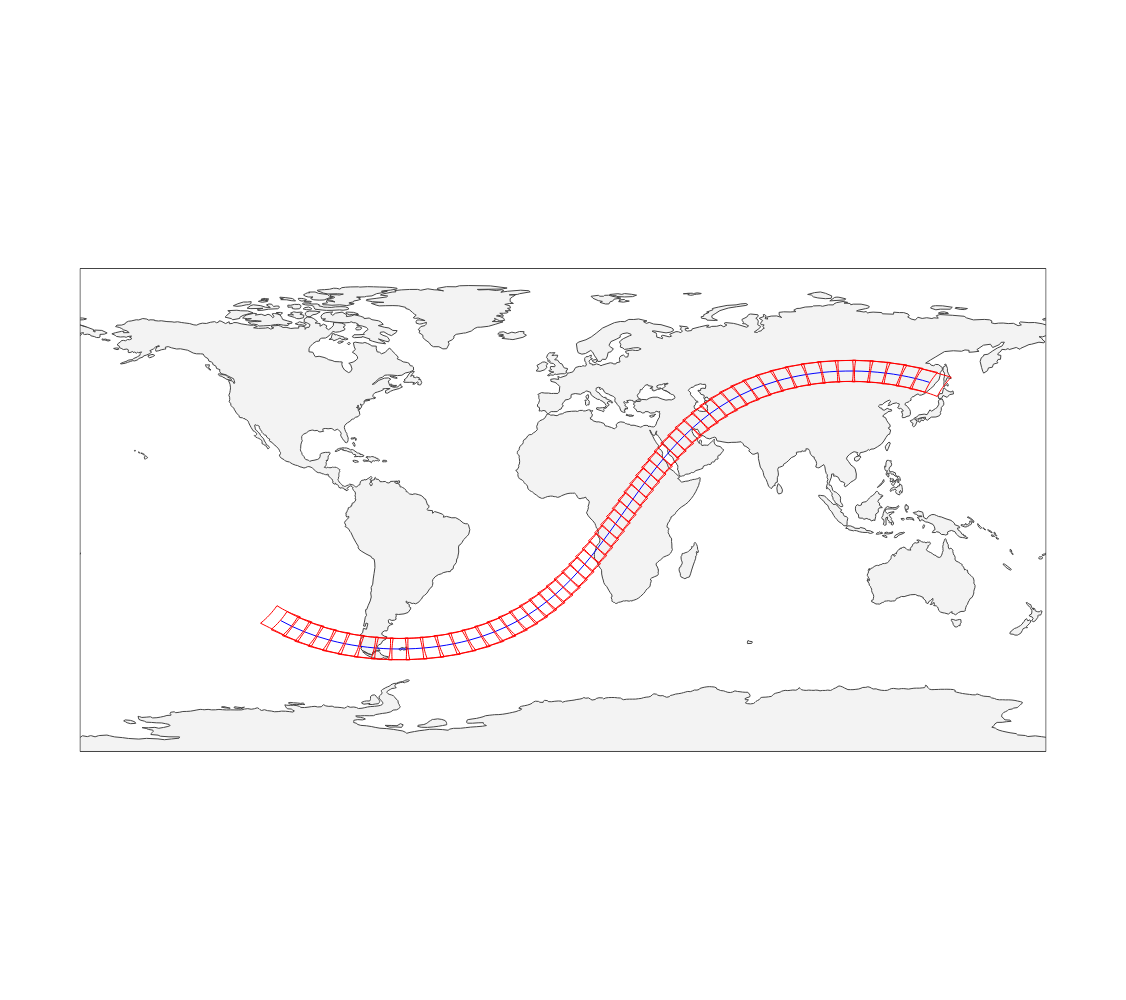

In [110]:
data = []

data.append(
    dict(
        type = 'scattergeo',
        lon = ground_track_df['Longitude'],
        lat = ground_track_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'blue',
        )
    )
)

[data.append(
    dict(
        type = 'scattergeo',
        lon = intersection_df['Longitude'],
        lat = intersection_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'red',
        )
    )
) for intersection_df in intersection_dfs]
    
layout = dict(
        title = None,
        showlegend = False,
        height=1000,
        geo = dict(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict(data=data, layout=layout)
iplot(fig)

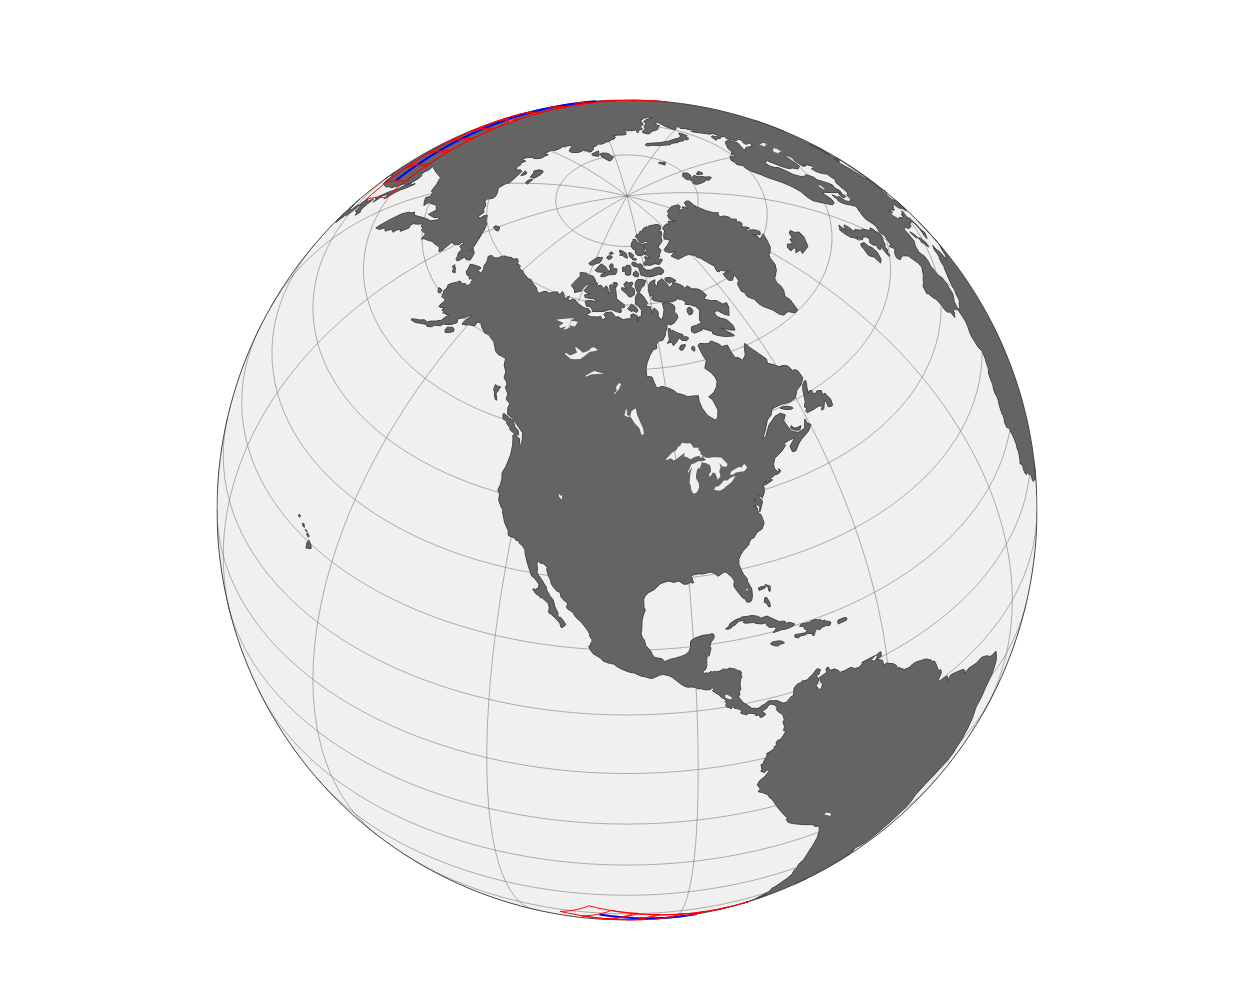

In [111]:
data = []

data.append( dict(
    type = 'scattergeo',
    lon = ground_track_df['Longitude'],
    lat = ground_track_df['Latitude'],
    mode = 'lines',
    line = dict(
        width = 2,
        color = 'blue'
    )
) )

[data.append(
    dict(
        type = 'scattergeo',
        lon = intersection_df['Longitude'],
        lat = intersection_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'red',
        )
    )
) for intersection_df in intersection_dfs]

layout = dict(
        title = None,
        showlegend = False,
        height=1000,
        geo = dict(
            showland = True,
            showlakes = True,
            showcountries = False,
            showocean = True,
            countrywidth = 0.0,
            landcolor = 'rgb(100, 100, 100)',
            lakecolor = 'rgb(240, 240, 240)',
            oceancolor = 'rgb(240, 240, 240)',
            projection = dict( 
                type = 'orthographic',
                rotation = dict(
                    lon = -100,
                    lat = 40,
                    roll = 0
                )            
            ),
            lonaxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            ),
            lataxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            )
        )
    )
    
fig = dict(data=data, layout=layout)

iplot(fig)